# Logistic Regression, Decision Tree and Random Forest  Predicting Customer Loss with R 

## IMport Data 

In [1]:
library(plyr)
library(corrplot)
library(ggplot2)
library(gridExtra)
library(ggthemes)
library(caret)
library(MASS)
library(randomForest)
library(party)

corrplot 0.84 loaded

Loading required package: lattice

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:ggplot2':

    margin


Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4


Attaching package: 'modeltools'


The following object is masked from 'package:plyr':

    empty


Loading required package: strucchange

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich



In [5]:
churn <- read.csv('Customer-Churn.csv')
str(churn)

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

In [6]:
sapply(churn, function(x) sum(is.na(x)))

customerID           gender    SeniorCitizen          Partner 
               0                0                0                0 
      Dependents           tenure     PhoneService    MultipleLines 
               0                0                0                0 
 InternetService   OnlineSecurity     OnlineBackup DeviceProtection 
               0                0                0                0 
     TechSupport      StreamingTV  StreamingMovies         Contract 
               0                0                0                0 
PaperlessBilling    PaymentMethod   MonthlyCharges     TotalCharges 
               0                0                0               11 
           Churn 
               0

In [7]:
churn <- churn[complete.cases(churn), ]

In [8]:
cols_recode1 <- c(10:15)
for(i in 1:ncol(churn[,cols_recode1])) {
        churn[,cols_recode1][,i] <- as.factor(mapvalues
                                              (churn[,cols_recode1][,i], from =c("No internet service"),to=c("No")))
}

In [9]:
churn$MultipleLines <- as.factor(mapvalues(churn$MultipleLines, 
                                           from=c("No phone service"),
                                           to=c("No")))

In [10]:
min(churn$tenure); max(churn$tenure)

[1] 1

[1] 72

In [11]:
group_tenure <- function(tenure){
    if (tenure >= 0 & tenure <= 12){
        return('0-12 Month')
    }else if(tenure > 12 & tenure <= 24){
        return('12-24 Month')
    }else if (tenure > 24 & tenure <= 48){
        return('24-48 Month')
    }else if (tenure > 48 & tenure <=60){
        return('48-60 Month')
    }else if (tenure > 60){
        return('> 60 Month')
    }
}
churn$tenure_group <- sapply(churn$tenure,group_tenure)
churn$tenure_group <- as.factor(churn$tenure_group)

In [13]:
churn$SeniorCitizen <- as.factor(mapvalues(churn$SeniorCitizen,
                                      from=c("0","1"),
                                      to=c("No", "Yes")))

In [14]:
churn$customerID <- NULL
churn$tenure <- NULL

## Exploratory data analysis and feature selection

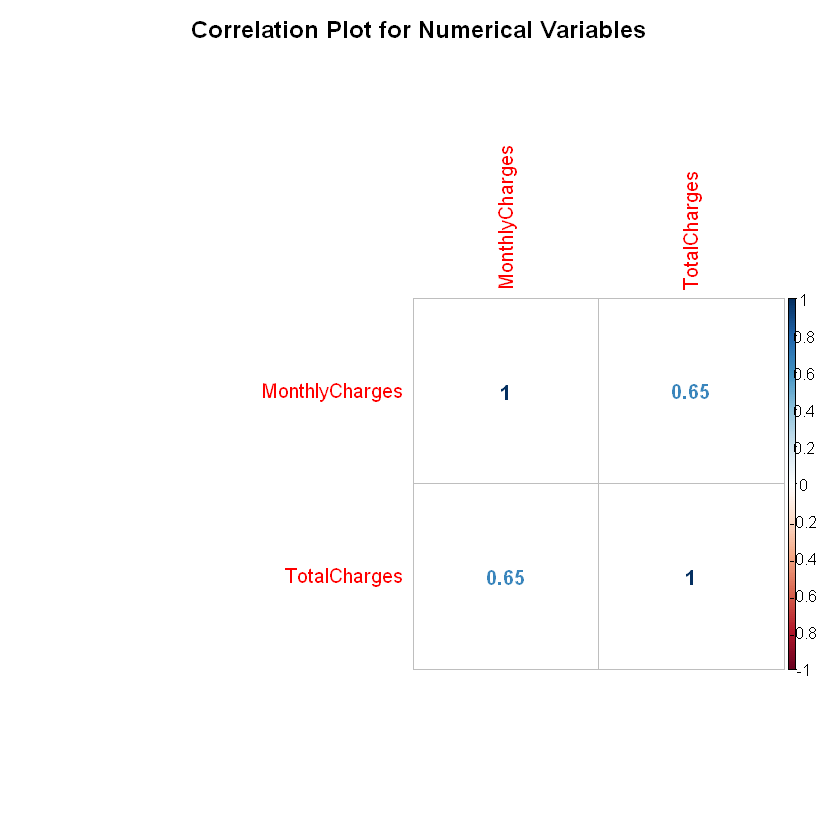

In [15]:
numeric.var <- sapply(churn, is.numeric)
corr.matrix <- cor(churn[,numeric.var])
corrplot(corr.matrix, main="\n\nCorrelation Plot for Numerical Variables", method="number")

In [16]:
churn$TotalCharges <- NULL

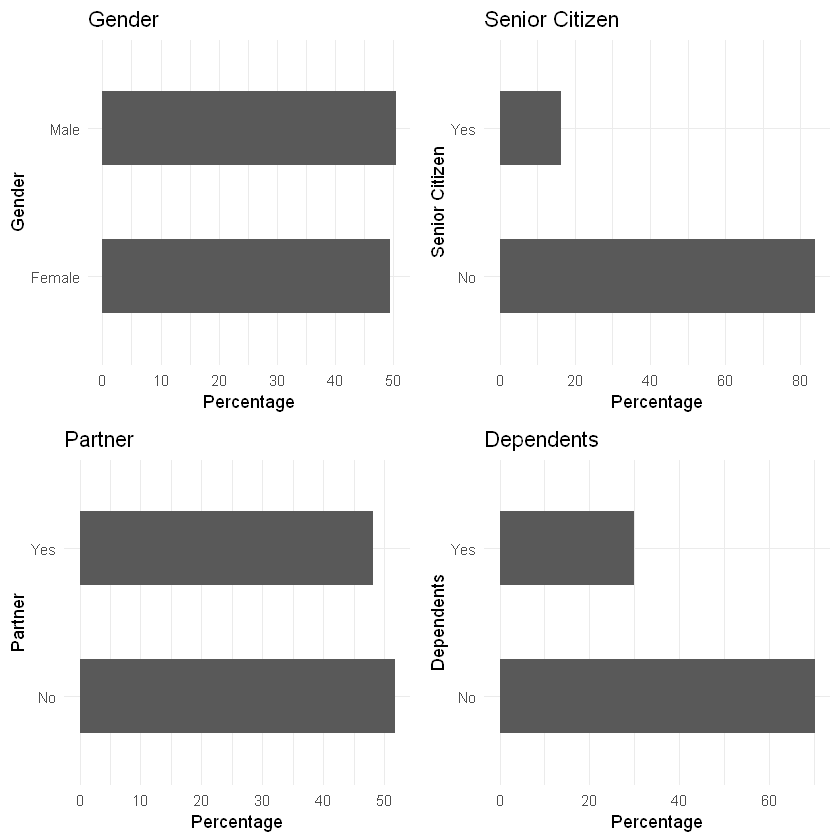

In [17]:
p1 <- ggplot(churn, aes(x=gender)) + ggtitle("Gender") + xlab("Gender") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p2 <- ggplot(churn, aes(x=SeniorCitizen)) + ggtitle("Senior Citizen") + xlab("Senior Citizen") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p3 <- ggplot(churn, aes(x=Partner)) + ggtitle("Partner") + xlab("Partner") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p4 <- ggplot(churn, aes(x=Dependents)) + ggtitle("Dependents") + xlab("Dependents") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
grid.arrange(p1, p2, p3, p4, ncol=2)

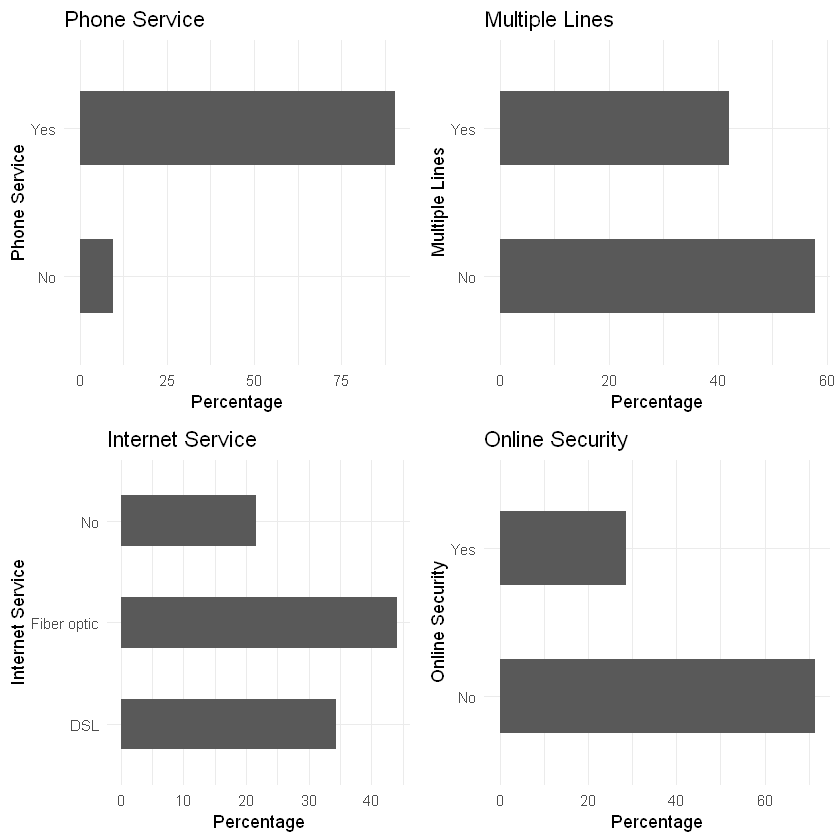

In [18]:
p5 <- ggplot(churn, aes(x=PhoneService)) + ggtitle("Phone Service") + xlab("Phone Service") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p6 <- ggplot(churn, aes(x=MultipleLines)) + ggtitle("Multiple Lines") + xlab("Multiple Lines") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p7 <- ggplot(churn, aes(x=InternetService)) + ggtitle("Internet Service") + xlab("Internet Service") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p8 <- ggplot(churn, aes(x=OnlineSecurity)) + ggtitle("Online Security") + xlab("Online Security") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
grid.arrange(p5, p6, p7, p8, ncol=2)

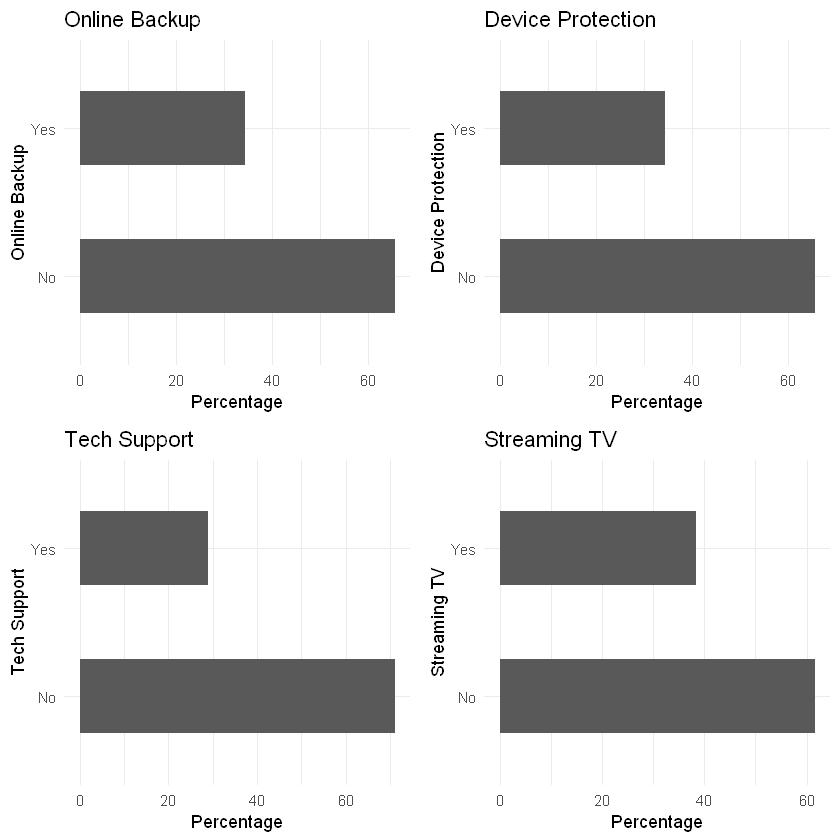

In [19]:
p9 <- ggplot(churn, aes(x=OnlineBackup)) + ggtitle("Online Backup") + xlab("Online Backup") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p10 <- ggplot(churn, aes(x=DeviceProtection)) + ggtitle("Device Protection") + xlab("Device Protection") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p11 <- ggplot(churn, aes(x=TechSupport)) + ggtitle("Tech Support") + xlab("Tech Support") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p12 <- ggplot(churn, aes(x=StreamingTV)) + ggtitle("Streaming TV") + xlab("Streaming TV") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
grid.arrange(p9, p10, p11, p12, ncol=2)

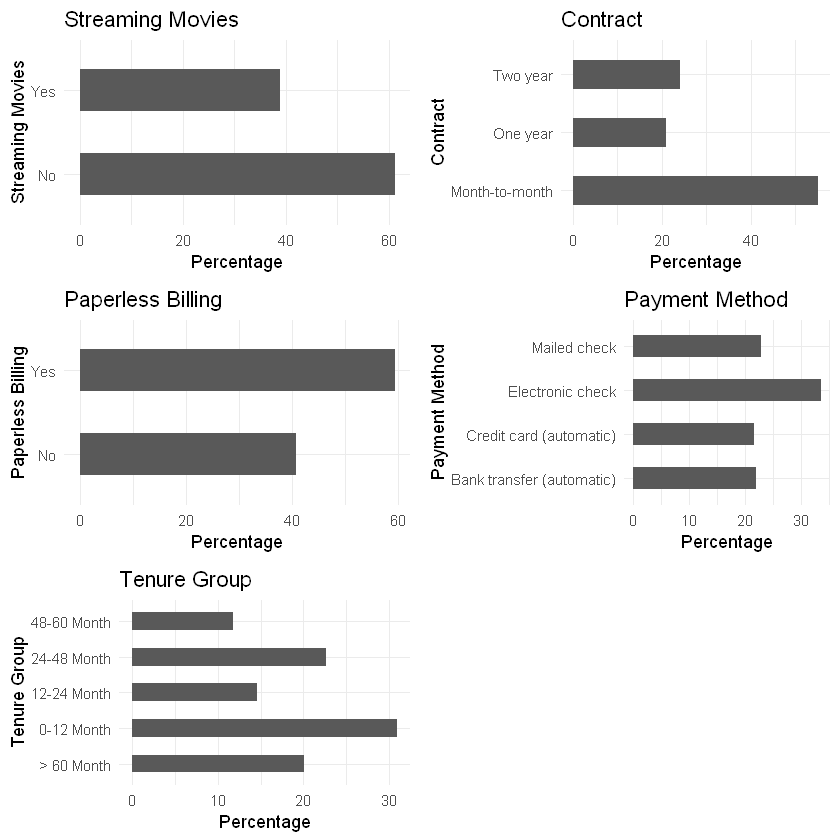

In [20]:
p13 <- ggplot(churn, aes(x=StreamingMovies)) + ggtitle("Streaming Movies") + xlab("Streaming Movies") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p14 <- ggplot(churn, aes(x=Contract)) + ggtitle("Contract") + xlab("Contract") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p15 <- ggplot(churn, aes(x=PaperlessBilling)) + ggtitle("Paperless Billing") + xlab("Paperless Billing") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p16 <- ggplot(churn, aes(x=PaymentMethod)) + ggtitle("Payment Method") + xlab("Payment Method") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p17 <- ggplot(churn, aes(x=tenure_group)) + ggtitle("Tenure Group") + xlab("Tenure Group") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
grid.arrange(p13, p14, p15, p16, p17, ncol=2)

## Logistic Regression

In [21]:
intrain<- createDataPartition(churn$Churn,p=0.7,list=FALSE)
set.seed(2017)
training<- churn[intrain,]
testing<- churn[-intrain,]

In [22]:
dim(training); dim(testing)

[1] 4924   19

[1] 2108   19

In [23]:
LogModel <- glm(Churn ~ .,family=binomial(link="logit"),data=training)
print(summary(LogModel))


Call:
glm(formula = Churn ~ ., family = binomial(link = "logit"), data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9964  -0.6723  -0.2904   0.6629   3.0963  

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -9.275e-01  9.740e-01  -0.952  0.34097    
genderMale                           -6.852e-02  7.769e-02  -0.882  0.37779    
SeniorCitizenYes                      2.099e-01  9.999e-02   2.099  0.03578 *  
PartnerYes                            2.078e-02  9.152e-02   0.227  0.82037    
DependentsYes                        -2.007e-01  1.065e-01  -1.885  0.05946 .  
PhoneServiceYes                       5.057e-01  7.684e-01   0.658  0.51046    
MultipleLinesYes                      5.610e-01  2.097e-01   2.675  0.00747 ** 
InternetServiceFiber optic            1.991e+00  9.470e-01   2.102  0.03554 *  
InternetServiceNo                    -2.093e+00  9.556e-01  -2.191 

In [24]:
anova(LogModel, test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,4923,5702.760,NA
gender,1,1.730566e+00,4922,5701.029,1.883386e-01
SeniorCitizen,1,1.162500e+02,4921,5584.779,4.190082e-27
Partner,1,1.093739e+02,4920,5475.405,1.343849e-25
Dependents,1,4.298763e+01,4919,5432.418,5.508695e-11
PhoneService,1,1.702847e+00,4918,5430.715,1.919161e-01
MultipleLines,1,9.430621e+00,4917,5421.284,2.133920e-03
InternetService,2,4.616612e+02,4915,4959.623,5.643564e-101
OnlineSecurity,1,1.678338e+02,4914,4791.789,2.199427e-38


In [25]:
testing$Churn <- as.character(testing$Churn)
testing$Churn[testing$Churn=="No"] <- "0"
testing$Churn[testing$Churn=="Yes"] <- "1"
fitted.results <- predict(LogModel,newdata=testing,type='response')
fitted.results <- ifelse(fitted.results > 0.5,1,0)
misClasificError <- mean(fitted.results != testing$Churn)
print(paste('Logistic Regression Accuracy',1-misClasificError))

[1] "Logistic Regression Accuracy 0.804554079696395"


In [26]:
print("Confusion Matrix for Logistic Regression"); table(testing$Churn, fitted.results > 0.5)

[1] "Confusion Matrix for Logistic Regression"


   
    FALSE TRUE
  0  1394  154
  1   258  302

In [27]:
library(MASS)
exp(cbind(OR=coef(LogModel), confint(LogModel)))

Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),0.3955510,0.05857155,2.6684762
genderMale,0.9337757,0.80184976,1.0873692
SeniorCitizenYes,1.2335840,1.01379474,1.5004491
PartnerYes,1.0209978,0.85343352,1.2218190
DependentsYes,0.8181552,0.66346167,1.0073248
PhoneServiceYes,1.6581579,0.36796809,7.4871583
MultipleLinesYes,1.7523429,1.16231469,2.6450107
InternetServiceFiber optic,7.3203989,1.14696566,47.0079399
InternetServiceNo,0.1232775,0.01890126,0.8012303
OnlineSecurityYes,0.8795716,0.58124605,1.3301515


## Decision Tree

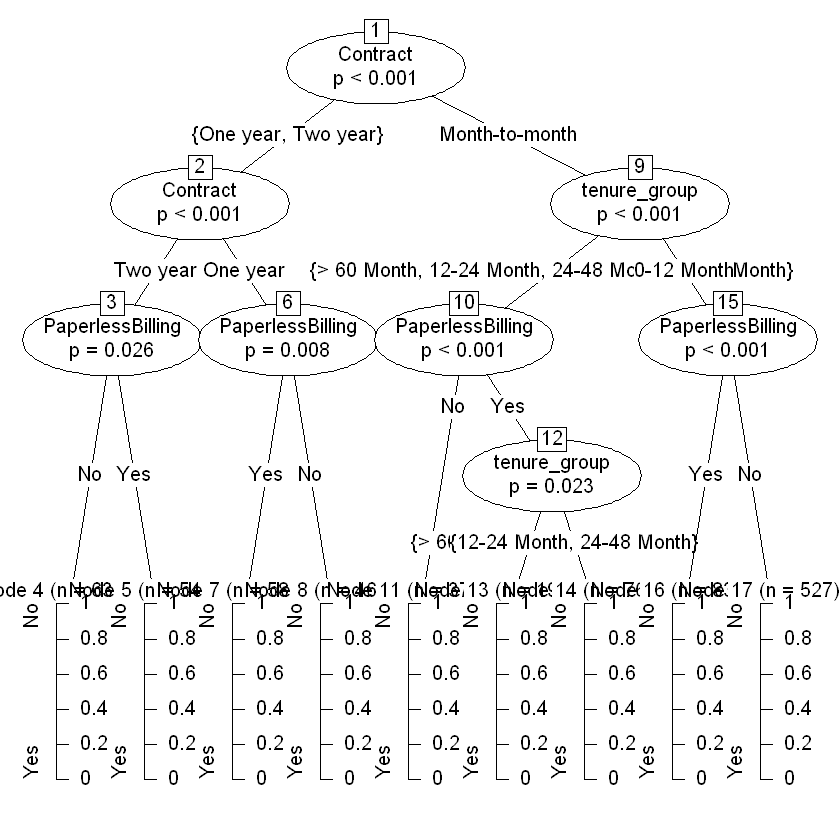

In [28]:
tree <- ctree(Churn~Contract+tenure_group+PaperlessBilling, training)
plot(tree)

In [29]:
pred_tree <- predict(tree, testing)
print("Confusion Matrix for Decision Tree"); table(Predicted = pred_tree, Actual = testing$Churn)

[1] "Confusion Matrix for Decision Tree"


         Actual
Predicted    0    1
      No  1384  327
      Yes  164  233

In [30]:
p1 <- predict(tree, training)
tab1 <- table(Predicted = p1, Actual = training$Churn)
tab2 <- table(Predicted = pred_tree, Actual = testing$Churn)
print(paste('Decision Tree Accuracy',sum(diag(tab2))/sum(tab2)))

[1] "Decision Tree Accuracy 0.76707779886148"


## Random Forest

In [31]:
rfModel <- randomForest(Churn ~., data = training)
print(rfModel)


Call:
 randomForest(formula = Churn ~ ., data = training) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 21.79%
Confusion matrix:
      No Yes class.error
No  3216 399   0.1103734
Yes  674 635   0.5148969


mtry = 4  OOB error = 21.32% 
Searching left ...
mtry = 8 	OOB error = 22.56% 
-0.05809524 0.05 
Searching right ...
mtry = 2 	OOB error = 20.69% 
0.02952381 0.05 


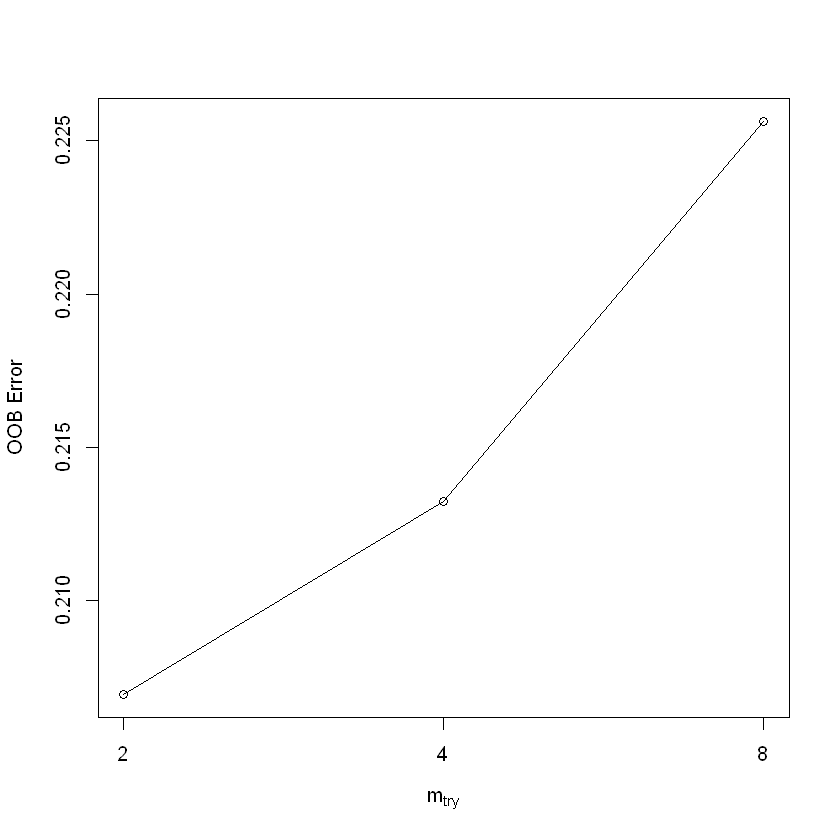

In [37]:
t <- tuneRF(training[, -18], training[, 18], stepFactor = 0.5, plot = TRUE, ntreeTry = 200, trace = TRUE, improve = 0.05)

In [38]:
rfModel_new <- randomForest(Churn ~., data = training, ntree = 200, mtry = 2, importance = TRUE, proximity = TRUE)
print(rfModel_new)


Call:
 randomForest(formula = Churn ~ ., data = training, ntree = 200,      mtry = 2, importance = TRUE, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 2

        OOB estimate of  error rate: 20.86%
Confusion matrix:
      No Yes class.error
No  3305 310   0.0857538
Yes  717 592   0.5477464


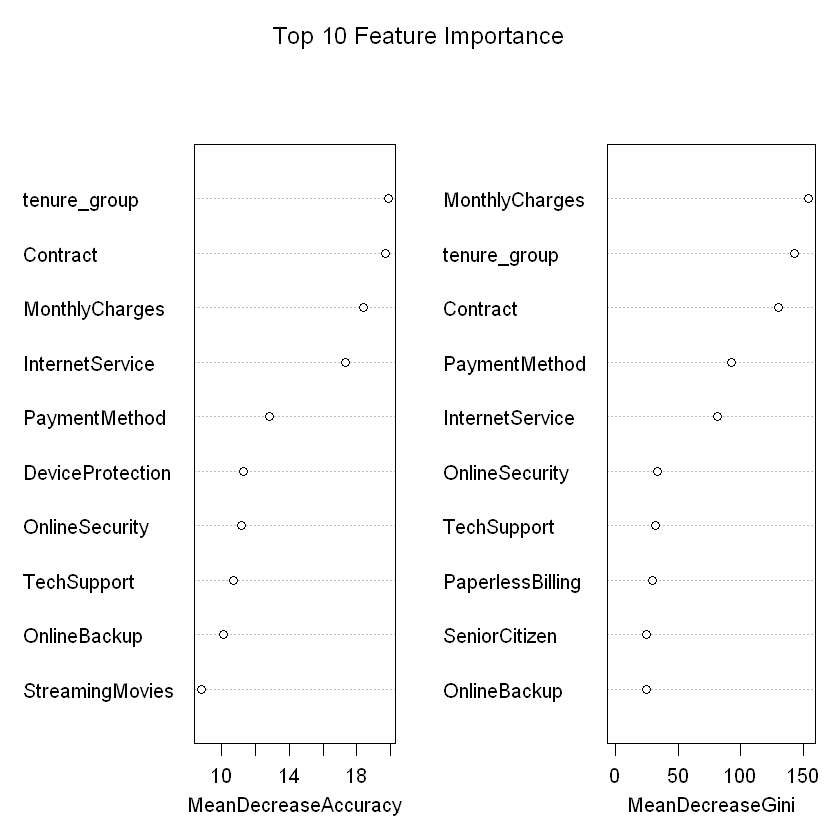

In [39]:
varImpPlot(rfModel_new, sort=T, n.var = 10, main = 'Top 10 Feature Importance')